In [1]:
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import Image

# I. Data preprocessing

In [2]:
OF = pd.read_pickle('Related_dataset/Opinion_Finder_result.pkl')
GPOMS = pd.read_pickle('Related_dataset/GPOMS_result.pkl')
DJIA = pd.read_csv("Related_dataset/DJIA_price.csv")

In [3]:
OF_prune = OF.drop(["tweets_processed", "tweet_size"], axis=1)
OF_prune.head()

,OF_transform
date_prune,
2020-04-09,-0.380042
2020-04-10,0.740977
2020-04-11,0.456476
2020-04-12,0.403397
2020-04-13,0.144374


In [4]:
GPOMS_prune = GPOMS.drop(["tweets_processed", "tweet_size", "GPOMS_preprocess_data", "sum_index", "avg_index"], axis=1)
GPOMS_prune.head()

,GPOMS_sum,GPOMS_avg
date_prune,,
2020-04-09,"[183.6299999999989, 539.3280000000003, -221.38...","[0.07336396324410663, 0.19152272727272737, -0...."
2020-04-10,"[93.32599999999992, 239.25200000000163, -94.83...","[0.09286169154228847, 0.19546732026143923, -0...."
2020-04-11,"[61.453999999999944, 349.1669999999983, -57.18...","[0.06188721047331314, 0.27888738019169196, -0...."
2020-04-12,"[87.4799999999995, 291.13600000000145, -60.822...","[0.0827625354777668, 0.21678034251675463, -0.0..."
2020-04-13,"[170.46399999999932, 537.4800000000009, -153.4...","[0.07969331463300576, 0.22274347285536714, -0...."


In [5]:
GPOMS_pivot = GPOMS_prune.copy()
GPOMS_pivot[['Calm','Kind','Happy','Alert','Sure','Vital']] = pd.DataFrame(GPOMS_prune.GPOMS_avg.tolist(), index= GPOMS_prune.index)
GPOMS_pivot = GPOMS_pivot.drop(['GPOMS_sum', 'GPOMS_avg'], axis=1)
GPOMS_pivot

,Calm,Kind,Happy,Alert,Sure,Vital
date_prune,,,,,,
2020-04-09,0.073364,0.191523,-0.115305,0.346767,0.136158,0.155670
2020-04-10,0.092862,0.195467,-0.102743,0.342314,0.130042,0.118410
2020-04-11,0.061887,0.278887,-0.064833,0.340592,0.101464,0.160457
2020-04-12,0.082763,0.216780,-0.062001,0.329557,0.111304,0.079260
2020-04-13,0.079693,0.222743,-0.091400,0.338160,0.130949,0.137338
...,...,...,...,...,...,...
2020-07-12,0.078391,0.181213,-0.097056,0.369545,0.147573,0.078480
2020-07-13,0.082311,0.183053,-0.082040,0.357759,0.154204,0.122646
2020-07-14,0.098220,0.186504,-0.089044,0.359141,0.150973,0.111742


In [6]:
DJIA_prune = DJIA.drop(["High", "Low", "Open", "Volume", 'Close'], axis=1)
DJIA_prune.head()

,Date,Adj Close
0,2020-04-08,23433.570312
1,2020-04-09,23719.369141
2,2020-04-13,23390.769531
3,2020-04-14,23949.759766
4,2020-04-15,23504.349609


In [7]:
GPOMS_pivot.describe()

,Calm,Kind,Happy,Alert,Sure,Vital
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.078792,0.187417,-0.103293,0.353102,0.143892,0.124640
std,0.020614,0.023966,0.022979,0.033254,0.020515,0.026918
min,-0.035162,0.129073,-0.162873,0.249179,0.101464,0.062168
25%,0.072884,0.171102,-0.115887,0.332083,0.130949,0.108165
50%,0.080006,0.183241,-0.102553,0.346434,0.140886,0.127082
75%,0.087458,0.200837,-0.091400,0.366016,0.153471,0.141128
max,0.117607,0.278887,-0.062001,0.461893,0.241158,0.182292


In [8]:
OF_prune.describe()

,OF_transform
count,77.000000
mean,0.004467
std,0.418874
min,-1.000000
25%,-0.271762
50%,-0.053079
75%,0.358811
max,1.000000


# II. Regression on Opinion Finder and GPOMS

In [9]:
corr_df = pd.DataFrame(columns=['coeff', 'p'])

print("-----The result of [norm]-----\n")
for col in GPOMS_pivot:
    # print(col)        
    r, p = stats.pearsonr(OF_prune['OF_transform'], GPOMS_pivot[col])
    corr_df.loc[col] = [r, p]
print(corr_df)

-----The result of [norm]-----

          coeff         p
Calm  -0.058164  0.615342
Kind   0.008086  0.944358
Happy  0.202458  0.077423
Alert  0.315122  0.005247
Sure  -0.141515  0.219572
Vital -0.381090  0.000628


Alert, Vital好像有關連:0

# III. Filled the missing value of DIJA (rolling based)

In [10]:
DJIA_dict = {}
for i, j in zip(DJIA_prune['Date'], DJIA_prune['Adj Close']): 
    date_obj = datetime.datetime.strptime(i, '%Y-%m-%d')
    DJIA_dict[date_obj] = j

In [11]:
DJIA_dict_filled = DJIA_dict.copy()
start_date = datetime.date(2020, 4, 9)
end_date = datetime.date(2020, 7, 16)

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

for single_date in daterange(start_date, end_date):
    query_date = single_date.strftime("%Y-%m-%d")
    query_date = datetime.datetime.strptime(query_date, '%Y-%m-%d')
    if query_date not in DJIA_dict_filled.keys(): # missing value
        i = -1
        before = query_date + datetime.timedelta(-1)
        while before not in DJIA_dict_filled.keys(): 
            before += datetime.timedelta(-1)
        i = 1
        after = query_date + datetime.timedelta(1)
        while after not in DJIA_dict_filled.keys(): 
            after += datetime.timedelta(1)
        before_val = DJIA_dict_filled[before]
        after_val = DJIA_dict_filled[after]
        mean_val = (before_val+after_val)/2
        DJIA_dict_filled[query_date] = mean_val

In [12]:
dates = list(DJIA_dict_filled.keys())
close = list(DJIA_dict_filled.values())

DJIA_df_filled = pd.DataFrame()
DJIA_df_filled['Dates'] = dates
DJIA_df_filled['Close'] = close
DJIA_df_filled = DJIA_df_filled.sort_values(by='Dates').reset_index(drop=True)
DJIA_df_filled

,Dates,Close
0,2020-04-08,23433.570312
1,2020-04-09,23719.369141
2,2020-04-10,23555.069336
3,2020-04-11,23472.919434
4,2020-04-12,23431.844482
...,...,...
95,2020-07-12,26083.175781
96,2020-07-13,26085.800781
97,2020-07-14,26642.589844
98,2020-07-15,26870.099609


In [13]:
# DJIA_df_filled.to_pickle('Related_dataset/DJIA_filled_missing_value.pkl')

In [14]:
DJIA_new_df = DJIA_df_filled.copy()
DJIA_new_df = DJIA_new_df.query(' "2020-04-09" <= Dates <= "2020-07-16"').reset_index(drop=True)

In [15]:
print("OF:")
print("start: ", OF_prune.index.min(), ", End: ", OF_prune.index.max())
print('Size: ', len(OF_prune['OF_transform']), '\n')

print("GPOMS:")
print("start: ", GPOMS_pivot.index.min(), ", End: ", GPOMS_pivot.index.max())
print('Size: ', len(GPOMS_pivot['Calm']), '\n')

print("DJIA:")
print("start: ", DJIA_new_df.Dates.min(), ", End: ", DJIA_new_df.Dates.max())
print('Size: ', len(DJIA_new_df['Dates']), )

OF:
start:  2020-04-09 , End:  2020-07-16
Size:  77 

GPOMS:
start:  2020-04-09 , End:  2020-07-16
Size:  77 

DJIA:
start:  2020-04-09 00:00:00 , End:  2020-07-16 00:00:00
Size:  99


推文有缺資料，20幾天沒有:0

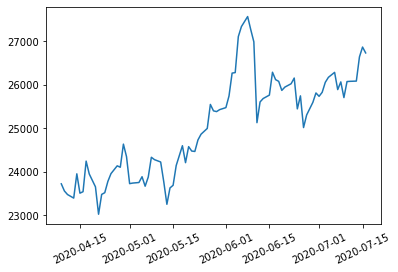

In [16]:
plt.plot(DJIA_new_df['Dates'], DJIA_new_df['Close'])
plt.xticks(rotation=25)
plt.show()

In [17]:
close_df = DJIA_new_df.copy()

close_df['yesterday'] = close_df['Close'].shift(1) #昨天
close_df.rename(columns = {'Close':'Today_close'}, inplace = True)
close_df['delta'] = close_df['Today_close']-close_df['yesterday'] 
close_df = close_df.drop(columns=['yesterday'])
close_df['Dates'] = close_df['Dates'].astype(str)
close_df.head()

,Dates,Today_close,delta
0,2020-04-09,23719.369141,NaN
1,2020-04-10,23555.069336,-164.299805
2,2020-04-11,23472.919434,-82.149902
3,2020-04-12,23431.844482,-41.074951
4,2020-04-13,23390.769531,-41.074951


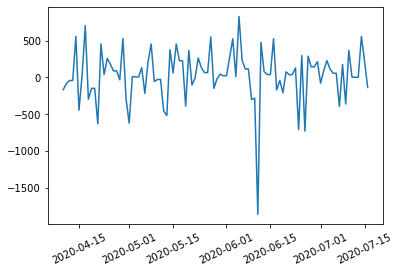

In [18]:
tmp = close_df.copy()
tmp['Dates'] = pd.to_datetime(tmp['Dates'], format="%Y-%m-%d")
plt.plot(tmp['Dates'], tmp['delta'])
plt.xticks(rotation=25)
plt.show()

In [19]:
OF_prune_r = OF_prune.reset_index()
OF_prune_r = OF_prune_r.rename(columns={'date_prune': 'Dates'})
GPOMS_pivot_r = GPOMS_pivot.reset_index()
GPOMS_pivot_r = GPOMS_pivot_r.rename(columns={'date_prune': 'Dates'})

In [20]:
combine_df = OF_prune_r.merge(GPOMS_pivot_r, on='Dates', how='inner')
combine_df = combine_df.merge(close_df, on='Dates', how='left')
combine_df = combine_df.query("'2020-04-10' <= Dates <= '2020-07-16'")
combine_df

,Dates,OF_transform,Calm,Kind,Happy,Alert,Sure,Vital,Today_close,delta
1,2020-04-10,0.740977,0.092862,0.195467,-0.102743,0.342314,0.130042,0.118410,23555.069336,-164.299805
2,2020-04-11,0.456476,0.061887,0.278887,-0.064833,0.340592,0.101464,0.160457,23472.919434,-82.149902
3,2020-04-12,0.403397,0.082763,0.216780,-0.062001,0.329557,0.111304,0.079260,23431.844482,-41.074951
4,2020-04-13,0.144374,0.079693,0.222743,-0.091400,0.338160,0.130949,0.137338,23390.769531,-41.074951
5,2020-04-14,-0.343949,0.080006,0.206345,-0.146017,0.345684,0.172988,0.127082,23949.759766,558.990234
...,...,...,...,...,...,...,...,...,...,...
72,2020-07-12,0.235669,0.078391,0.181213,-0.097056,0.369545,0.147573,0.078480,26083.175781,2.625000
73,2020-07-13,-0.322718,0.082311,0.183053,-0.082040,0.357759,0.154204,0.122646,26085.800781,2.625000
74,2020-07-14,-0.271762,0.098220,0.186504,-0.089044,0.359141,0.150973,0.111742,26642.589844,556.789062
75,2020-07-15,0.002123,0.084568,0.184610,-0.079527,0.337375,0.146182,0.102206,26870.099609,227.509766


# IV. Granger Causality

Granger Causality test is used to determine **whether or not one time series is useful for forecasting another.**

This test uses the following null and alternative hypotheses:

> **Null Hypothesis (H0): Time series x does not Granger-cause time series y**

> **Alternative Hypothesis (HA): Time series x Granger-causes time series y**


If the p-value is less than a certain significance level (i.e. α = .05), then we can reject the null hypothesis and conclude that we have sufficient evidence to say that time series x Granger-causes time series y.

***on opinion finder***

In [21]:
# Perform Granger-Causality test on DJIA index directly! (alpha=0.05)
from statsmodels.tsa.stattools import grangercausalitytests

# 1. Test if it have the predictive power on DJIA
print("OF on adj close:")
lag_list1 = []
p_list1 = []
for lag in range(1, 10): 
    res1 = grangercausalitytests(combine_df[['Today_close', 'OF_transform']], maxlag=[lag]) 
    lag_list1.append(lag)
    p_list1.append(res1[lag][0]['ssr_ftest'][1]) # parameter: max_lag/0/f test/p_value

OF_adj_df = pd.DataFrame({'max_lag':lag_list1, 'p_value':p_list1})
OF_adj_df = OF_adj_df.sort_values(by='p_value', ascending=True).reset_index(drop=True)

OF on adj close:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2360  , p=0.6286  , df_denom=72, df_num=1
ssr based chi2 test:   chi2=0.2458  , p=0.6201  , df=1
likelihood ratio test: chi2=0.2454  , p=0.6203  , df=1
parameter F test:         F=0.2360  , p=0.6286  , df_denom=72, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4948  , p=0.2315  , df_denom=69, df_num=2
ssr based chi2 test:   chi2=3.2062  , p=0.2013  , df=2
likelihood ratio test: chi2=3.1386  , p=0.2082  , df=2
parameter F test:         F=1.4948  , p=0.2315  , df_denom=69, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0125  , p=0.3929  , df_denom=66, df_num=3
ssr based chi2 test:   chi2=3.3597  , p=0.3394  , df=3
likelihood ratio test: chi2=3.2847  , p=0.3498  , df=3
parameter F test:         F=1.0125  , p=0.3929  , df_denom=66, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5650  ,

In [22]:
# 2. Test if it have the predictive power on the change(delta) of DJIA
print("OF on delta Change: ")
lag_list2 = []
p_list2 = []
for lag in range(1, 10): 
    res2 = grangercausalitytests(combine_df[['delta', 'OF_transform']], maxlag=[lag]) 
    lag_list2.append(lag)
    p_list2.append(res2[lag][0]['ssr_ftest'][1]) # parameter: max_lag/0/f test/p_value

OF_delta_df = pd.DataFrame({'max_lag':lag_list2, 'p_value':p_list2})
OF_delta_df = OF_delta_df.sort_values(by='p_value', ascending=True).reset_index(drop=True)

OF on delta Change: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2029  , p=0.6537  , df_denom=72, df_num=1
ssr based chi2 test:   chi2=0.2114  , p=0.6457  , df=1
likelihood ratio test: chi2=0.2111  , p=0.6459  , df=1
parameter F test:         F=0.2029  , p=0.6537  , df_denom=72, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6734  , p=0.1951  , df_denom=69, df_num=2
ssr based chi2 test:   chi2=3.5893  , p=0.1662  , df=2
likelihood ratio test: chi2=3.5050  , p=0.1733  , df=2
parameter F test:         F=1.6734  , p=0.1951  , df_denom=69, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3135  , p=0.2774  , df_denom=66, df_num=3
ssr based chi2 test:   chi2=4.3584  , p=0.2253  , df=3
likelihood ratio test: chi2=4.2332  , p=0.2374  , df=3
parameter F test:         F=1.3135  , p=0.2774  , df_denom=66, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.595

***on opinion finder***

In [23]:
GPOMS_cols = ['Calm', 'Kind', 'Happy', 'Alert', 'Sure','Vital']

print("GPOMS on Adj close: ")
sent_types3 = []
lag_list3 = []
p_list3 = []
for lag in range(1, 10): 
    for col in GPOMS_cols:
        res3 = grangercausalitytests(combine_df[['Today_close', col]], maxlag=[lag]) 
        sent_types3.append(col)
        lag_list3.append(lag)
        p_list3.append(res3[lag][0]['ssr_ftest'][1]) # parameter: max_lag/0/f test/p_value

GPOMS_close_df = pd.DataFrame({'type':sent_types3, 'max_lag':lag_list3, 'p_value':p_list3})
GPOMS_close_df = GPOMS_close_df.sort_values(by='p_value', ascending=True).reset_index(drop=True)

GPOMS on Adj close: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1428  , p=0.7066  , df_denom=72, df_num=1
ssr based chi2 test:   chi2=0.1487  , p=0.6997  , df=1
likelihood ratio test: chi2=0.1486  , p=0.6999  , df=1
parameter F test:         F=0.1428  , p=0.7066  , df_denom=72, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0281  , p=0.8672  , df_denom=72, df_num=1
ssr based chi2 test:   chi2=0.0293  , p=0.8640  , df=1
likelihood ratio test: chi2=0.0293  , p=0.8641  , df=1
parameter F test:         F=0.0281  , p=0.8672  , df_denom=72, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4542  , p=0.5025  , df_denom=72, df_num=1
ssr based chi2 test:   chi2=0.4731  , p=0.4916  , df=1
likelihood ratio test: chi2=0.4716  , p=0.4922  , df=1
parameter F test:         F=0.4542  , p=0.5025  , df_denom=72, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.444

ssr based F test:         F=0.4528  , p=0.8639  , df_denom=54, df_num=7
ssr based chi2 test:   chi2=4.0497  , p=0.7740  , df=7
likelihood ratio test: chi2=3.9354  , p=0.7872  , df=7
parameter F test:         F=0.4528  , p=0.8639  , df_denom=54, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.5021  , p=0.8490  , df_denom=51, df_num=8
ssr based chi2 test:   chi2=5.3556  , p=0.7190  , df=8
likelihood ratio test: chi2=5.1552  , p=0.7409  , df=8
parameter F test:         F=0.5021  , p=0.8490  , df_denom=51, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.5785  , p=0.7907  , df_denom=51, df_num=8
ssr based chi2 test:   chi2=6.1711  , p=0.6281  , df=8
likelihood ratio test: chi2=5.9070  , p=0.6577  , df=8
parameter F test:         F=0.5785  , p=0.7907  , df_denom=51, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6041  , p=0.7700  , df_denom=51, df_num=8
ssr based chi2 test:   chi2=

In [24]:
print("GPOMS on delta: ")
sent_types4 = []
lag_list4 = []
p_list4 = []
for lag in range(1, 10): 
    for col in GPOMS_cols:
        res4 = grangercausalitytests(combine_df[['delta', col]], maxlag=[lag]) 
        sent_types4.append(col)
        lag_list4.append(lag)
        p_list4.append(res4[lag][0]['ssr_ftest'][1]) # parameter: max_lag/0/f test/p_value

GPOMS_delta_df = pd.DataFrame({'type':sent_types4, 'max_lag':lag_list4, 'p_value':p_list4})
GPOMS_delta_df = GPOMS_delta_df.sort_values(by='p_value', ascending=True).reset_index(drop=True)

GPOMS on delta: 

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4655  , p=0.4973  , df_denom=72, df_num=1
ssr based chi2 test:   chi2=0.4849  , p=0.4862  , df=1
likelihood ratio test: chi2=0.4833  , p=0.4869  , df=1
parameter F test:         F=0.4655  , p=0.4973  , df_denom=72, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1237  , p=0.7261  , df_denom=72, df_num=1
ssr based chi2 test:   chi2=0.1289  , p=0.7196  , df=1
likelihood ratio test: chi2=0.1288  , p=0.7197  , df=1
parameter F test:         F=0.1237  , p=0.7261  , df_denom=72, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0001  , p=0.9939  , df_denom=72, df_num=1
ssr based chi2 test:   chi2=0.0001  , p=0.9937  , df=1
likelihood ratio test: chi2=0.0001  , p=0.9937  , df=1
parameter F test:         F=0.0001  , p=0.9939  , df_denom=72, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6910  ,

likelihood ratio test: chi2=6.8135  , p=0.4486  , df=7
parameter F test:         F=0.8006  , p=0.5903  , df_denom=54, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.3947  , p=0.2266  , df_denom=54, df_num=7
ssr based chi2 test:   chi2=12.4751 , p=0.0860  , df=7
likelihood ratio test: chi2=11.4672 , p=0.1195  , df=7
parameter F test:         F=1.3947  , p=0.2266  , df_denom=54, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.4949  , p=0.8542  , df_denom=51, df_num=8
ssr based chi2 test:   chi2=5.2793  , p=0.7273  , df=8
likelihood ratio test: chi2=5.0844  , p=0.7485  , df=8
parameter F test:         F=0.4949  , p=0.8542  , df_denom=51, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8216  , p=0.5873  , df_denom=51, df_num=8
ssr based chi2 test:   chi2=8.7642  , p=0.3626  , df=8
likelihood ratio test: chi2=8.2437  , p=0.4100  , df=8
parameter F test:         F=0.8216  , p=0.587

# Result

In [38]:
OF_adj_df.head()

,max_lag,p_value
0,5,0.168686
1,4,0.194619
2,2,0.231474
3,7,0.357594
4,6,0.370591


In [39]:
OF_delta_df.head()

,max_lag,p_value
0,5,0.112861
1,4,0.186545
2,2,0.195129
3,6,0.232892
4,3,0.277443


In [43]:
GPOMS_close_df.head()

,type,max_lag,p_value
0,Sure,1,0.050295
1,Alert,5,0.118427
2,Alert,4,0.128675
3,Sure,2,0.158982
4,Kind,3,0.165485


In [41]:
GPOMS_delta_df.head()

,type,max_lag,p_value
0,Sure,1,0.021920
1,Alert,4,0.060997
2,Sure,2,0.089108
3,Alert,5,0.094984
4,Alert,9,0.105352
